IMPORTS

In [4]:
%matplotlib inline  
import os
import numpy as np
import matplotlib.pyplot as plt
from smt.applications import EGO

import matplotlib.font_manager

import warnings
warnings.filterwarnings("ignore")
     
from scipy.stats import norm
from scipy.optimize import minimize

from smt.utils.options_dictionary import OptionsDictionary
from smt.applications.application import SurrogateBasedApplication
from smt.utils.misc import compute_rms_error

from smt.surrogate_models import KPLS, KRG, KPLSK
from smt.sampling_methods import LHS

In [5]:

def convergence_plot(res_crit, dim, budget, inc_norm, k, ax, q, color, cv_time):
    """
    Plot a convergence line for a specific optimizer for a specific problem
    Parameters
    ----------
    res_crit :Dict
        Dictionarie containing the results of a specific optimization for a specific problem for a specific criteria.
    dim :int
        Number of variables of the regarded problem.
    budget :int
        Budget of the optimization. NB :number of evaluations :budget * dim
    inc_norm :float
        normalisation factor of the standard deviation of the results.
    k :int
        Plot number.
    ax :Axes
        Ax of plot.
    q :int
        Problem number.
    color :list
        List of colors.
    cv_time :bool
        True if Convergence plot in time, False for convergence plot in number fo iterations.
    Returns
    -------
    line :Line2D
        Line of the convergence plot.
    """
    itera = np.asarray(range(1, dim * budget + 1))

    evol_crit = res_crit["evol"]["val"]
    err_crit = (
        np.mean(evol_crit, axis=0) + np.sqrt(np.var(evol_crit, axis=0)) / inc_norm[q]
    )
    min_err_crit = (
        np.mean(evol_crit, axis=0) - np.sqrt(np.var(evol_crit, axis=0)) / inc_norm[q]
    )

    itera = itera[0 : res_crit["evol"]["nb_doe"]]
    evol_crit = evol_crit[:, 0 : res_crit["evol"]["nb_doe"]]
    min_err_crit = min_err_crit[0 : res_crit["evol"]["nb_doe"]]
    err_crit = err_crit[0 : res_crit["evol"]["nb_doe"]]

    ## Change that when needed
    # evol_crit = evol_crit[:,dim+1::]
    # itera = itera[0:res_crit['evol']['nb_doe']-dim-1]
    # err_crit = err_crit[dim+1::]
    # min_err_crit = min_err_crit[dim+1::]

    # evol_crit = evol_crit[:, dim - 2 ::]
    # itera = itera[dim - 2 ::]
    # err_crit = err_crit[dim - 2 ::]
    # min_err_crit = min_err_crit[dim - 2 ::]

    if cv_time:
        time_mean = res_crit["evol"]["time"][-1] / (3600.0 * len(itera))
        itera = np.asarray(range(len(itera)))
        itera = time_mean * itera

    (line,) = ax.plot(itera, np.mean(evol_crit, axis=0), c=color[k])
    ax.fill_between(itera, min_err_crit, err_crit, alpha=0.1, color=color[k])
    ax.plot(itera, err_crit, c=color[k], linestyle="--", alpha=0.5)
    ax.plot(itera, min_err_crit, c=color[k], linestyle="--", alpha=0.5)
    plt.setp(ax.yaxis.get_majorticklabels(), rotation="vertical", va="center")
    return line

In [6]:
namefun=['Branin_5','Set_1','Set_2','Wong1','Branin_1','Branin_2','Goldstein_1','Cos_1','Spiral','EVD52','Rosen-Suzuki']
namefun=['Branin_5']

suffix_xsave = 'xsave.npy'
suffix_ysave = 'ysave.npy'

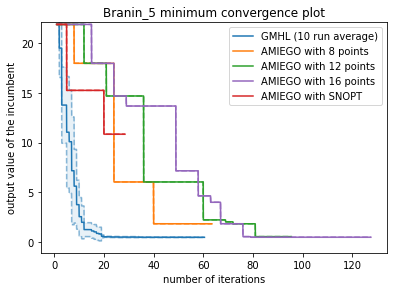

In [8]:
methods=["","AMIEGO_8_","AMIEGO_12_","AMIEGO_16_","AMIEGO_SNOPT_"]

rapport=1
select_color = range(len(methods)+1)
u=-10e8
l=10e8
nb_pt_plot=30*60
for base_save in namefun: 
    fig= plt.figure()  
    dir_name='./results/'+base_save+"/"
    k2=0
    for method in methods:
        n_optim=10
        n_doe=2
        n_iter=60
        if (method=="AMIEGO_8_") :
            n_doe=2
            n_iter= 63
            n_optim=1
        if (method=="AMIEGO_12_") :
            n_doe=2
            n_iter= 95
            n_optim=1
        if (method=="AMIEGO_16_") :
            n_doe=2
            n_iter= 127
            n_optim=1
        if (method=="AMIEGO_SNOPT_") :
            n_doe=2
            n_iter= 28
            n_optim=1
        y_data=np.zeros((n_optim,n_iter+n_doe))
        mini=np.zeros((n_optim,n_iter))
        for k in range(n_optim):
            filename= os.path.join(dir_name, base_save+"_"+str(k) +"_optim_"+method+suffix_ysave)
            yl=np.load(filename) 
            y_data[k,:]=yl.T[0]
            for i in range(n_iter) : 
                mini[k,i]=(np.min(yl[0:n_doe+i+1]))
        Moy_mini=mini.sum(axis=0)/n_optim
        Var_mini=np.var(mini, axis=0)
        ubm = Moy_mini + np.sqrt(Var_mini)/rapport  
        lbm =  Moy_mini - np.sqrt(Var_mini)/rapport

        x_plot = np.linspace(1,n_iter+0.5, nb_pt_plot)
        y_plot_min=np.copy(x_plot)
        min_err_crit=np.copy(x_plot)
        err_crit=np.copy(x_plot)

        if (method=="") :
            method="GMHL (10 run average)"
        if (method=="AMIEGO_8_") :
            method="AMIEGO with 8 points"
        if (method=="AMIEGO_12_") :
            method="AMIEGO with 12 points"
        if (method=="AMIEGO_16_") :
            method="AMIEGO with 16 points"  
        if (method=="AMIEGO_SNOPT_") :
            method="AMIEGO with SNOPT"
            
        for i in range(nb_pt_plot) :
            y_plot_min[i]=Moy_mini[int(np.floor(x_plot[i]))-1]
            err_crit[i] =ubm[int(np.floor(x_plot[i]))-1] 
            min_err_crit[i] = lbm[int(np.floor(x_plot[i]))-1]
        
        color = np.asarray(np.append(np.asarray(["C%d" % i for i in range(10)] * 8), ["b", "m", "k"]))
        color = color[select_color]
        if k2==3:
            k2=4
        if k2==5:
            k2=3
            
        u= max(np.floor(max(y_plot_min))+0.05*abs(np.floor(max(y_plot_min)-min(y_plot_min))),u)
        l= min(max(np.floor(min(y_plot_min))-0.05*abs(np.floor(max(y_plot_min)-min(y_plot_min))),-1000),l)
        axes = fig.add_axes([0.1,0.1,0.8,0.8])
        if (method=="all") :
            axes.plot(x_plot,y_plot_min,label="min of the 16 continuous optimizations",c=color[k2])
            axes.fill_between(x_plot, min_err_crit, err_crit, alpha=0.1, color=color[k2])
            axes.plot(x_plot, err_crit, c=color[k2], linestyle="--", alpha=0.5)
            axes.plot(x_plot, min_err_crit, c=color[k2], linestyle="--", alpha=0.5)

        else: 
            axes.plot(x_plot,y_plot_min,label=method,c=color[k2])
            axes.fill_between(x_plot, min_err_crit, err_crit, alpha=0.1, color=color[k2])
            axes.plot(x_plot, err_crit, c=color[k2], linestyle="--", alpha=0.5)
            axes.plot(x_plot, min_err_crit, c=color[k2], linestyle="--", alpha=0.5)

        k2=k2+1
    
    
    
        
axes.set_ylim([l,u])
plt.legend()
plt.title("{func} minimum convergence plot".format(func=base_save), loc='center')
plt.xlabel("number of iterations")
plt.ylabel("output value of the incumbent")
plt.savefig("./results/"+base_save+"/minimum convergence plot between GMHL and AMIEGO",dpi=500,quality=299)
plt.show()

